# Machine Learning: Predicting GDP Growth with 3 Month T-Bill Rates

In [3]:
import matplotlib.pyplot as plt, csv, datetime as dt #import matlab plotting, file reader functions, and datetime function

## Introduction
The goal of this project was to predict GDP growth with 3 Month T-Bill Rates. No assumptions were made. Data used were real GDP values from 1/1/66 to 7/1/16 and 3 Month T-Bill Rates from 1/1/66 to 7/1/16 from FRED compiled by the St. Louis Fed. Methodolgy used was a linear regression to determine correlation between GDP growth and 3 Month T-Bill Rates. 

## CSV Data Extraction 

### CSV Reader Version 1
Conversion of CSV data into a Python dictionary without use of csv.DictReader. The end result is the same, but Version 2 is far cleaner.

    with open('gdp_real.csv', newline = '') as csvfile: #import GDP data
        gdpreader = csv.reader(csvfile) #use of csv.reader 
        headers = next(gdpreader)
        gdp_data = {header:[] for header in headers}
        for row in gdpreader:
            for header in headers:
                gdp_data[header].append(row[headers.index(header)])

### CSV Reader Version 2 (Current)

In [4]:
with open('gdp_real.csv', newline = '') as csvfile: #import GDP data
    gdpreader = csv.DictReader(csvfile) #use of csv.DictReader 
    gdp_data = {}
    for row in gdpreader:
        for column, value in row.items():
            gdp_data.setdefault(column, []).append(value)

### Date Format Parsing
My initial idea was to turn all dates into ordinals, which, as integers, are easier to work with than strings or datetime objects. However, ordinals would prove difficult to perform linear regresions on and graph given the large size of their numeric values. 
    
    def us_locale_to_ordinal(str_date):
        date = [int(x) for x in str_date.split('/')]
        if date[2] <= dt.date.today().year-2000:
            date[2] += 2000
        elif date[2] < 1900:
            date[2]+= 1900
        return dt.date.toordinal(dt.date(date[2], date[0], date[1]))

    gdp_data['DATE'] = [us_locale_to_ordinal(x) for x in gdp_data['DATE']]
    
Upon realizing the disadvantages, I chose to instead use a count of quarters since 1/1/66, the beginning of my data set.

In [5]:
# simplify date into quarters starting from 1/1/66
gdp_data['DATE'] = [i for i in range(len(gdp_data['DATE']))] 

### Conversion of all Data into Floats and Calculating Percent Change in GDP from Existing GDP Values

In [6]:
for header in gdp_data:
    gdp_data[header] = [float(x) for x in gdp_data[header]]
    
def percent_change(present, past):
    return (present-past)/past*100
gdp_data['PERCENT CHANGE IN GDP'] = [percent_change(gdp_data['REAL GDP VALUE'][i],gdp_data['REAL GDP VALUE'][i-1]) for i in range(1, len(gdp_data['REAL GDP VALUE']))]

## Analyzing the Data


###  Standard Linear Regression (In Progress)


In [ ]:
deltagdp_sd = numpy.std(gdp_data['PERCENT CHANGE IN GDP'])
tbillrate_sd = numpy.std()

### Tensorflow Linear Regression 
On hiatus until better understanding of Tensorflow is achieved

In [106]:
import tensorflow as tf, numpy as np #import tensorflow and numpy
rng = np.random
learning_rate = 0.01
training_epochs = 1000
display_steps = 50


Previous version of the Tensorflow linear regression (functional). 

    x = tf.placeholder(tf.float32, [None,1])
    a = tf.Variable(tf.zeros([1,1]))
    b = tf.Variable(tf.zeros([1]))
    y = tf.matmul(x,a)+b
    y_ = tf.placeholder(tf.float32, [None,1])
    
    gdp = tf.reduce_sum(tf.pow((y_-y),2))
    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(gdp)
    
    init = tf.initialize_all_variables()
    
    with tf.Session() as sess:
        sess.run(init)
        for tbillrate,gdp in deltagdp_vs_tbillrate:
            feed = {x: np.array([[tbillrate]]), y_: np.array([[gdp]])}
            sess.run(train_step, feed_dict = feed)
        a = sess.run(a)
        b = sess.run(b)

Current version (does not work):

    tbillrate = np.reshape(np.asarray(gdp_data['3 MONTH T-BILL VALUE'][1:]),(len(gdp_data['3 MONTH T-BILL VALUE'][1:]),1))
    delta_gdp = np.asarray(gdp_data['PERCENT CHANGE IN GDP'])

    x = tf.placeholder(tf.float32,[None,1])
    y_ = tf.placeholder(tf.float32,[None,1])
    a = tf.Variable(tf.zeros([1,1]))
    b = tf.Variable(tf.zeros([1]))
    y = tf.add(tf.matmul(x,a),b)

    cost = tf.reduce_sum(tf.square(y-y_))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            for tbillrate,deltagdp in zip(tbillrate, delta_gdp):
                feed = {x: tbillrate, y_: delta_gdp}
                sess.run(train_step, feed_dict = feed)
            if epoch % display_steps == 0:
                print(sess.run(cost, feed_dict={x:tbillrate, y_:delta_gdp}))

### Graphs

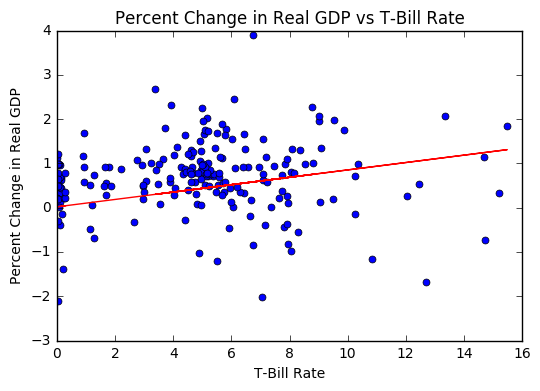

R-squared: -0.177712047427


In [57]:
x = gdp_data['3 MONTH T-BILL VALUE'][1:]
y = gdp_data['PERCENT CHANGE IN GDP']
y_line = [a[0][0]*y+b[0] for y in x]

plt.plot(x,y,'o',markersize=5)
plt.plot(x,y_line,'r')
plt.xlabel('T-Bill Rate')
plt.ylabel('Percent Change in Real GDP')
plt.title('Percent Change in Real GDP vs T-Bill Rate')
plt.show()

def squared_error(actual,compared_value):
    return pow(actual-compared_value,2)

mean = np.mean(gdp_data['PERCENT CHANGE IN GDP'])
sum_squares = sum([squared_error(actual,mean) for actual in gdp_data['PERCENT CHANGE IN GDP']])
sum_squares_resid = sum([squared_error(actual,predicted) for actual,predicted in zip(gdp_data['PERCENT CHANGE IN GDP'], y_line)])

r_squared = 1 - sum_squares_resid/sum_squares
print('R-squared:', r_squared)

### Conclusion Drawn from Tensorflow Regression
There is little to no linear correlation between T Bill Rate and Percent Change in Real GDP. This is most evident by the negative value of the R-squared value of the linear regression. Thus, using more economic variables is mandatory to understand the elements behind GDP fluctuation.